# Importing Libraries

In [18]:
import os
import numpy as np
from matplotlib import pyplot as plt
import random
from patchify import patchify

import cv2
import imageio.v2 as imageio
from PIL import Image

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Add, MaxPooling2D, UpSampling2D, Conv2DTranspose, Activation
from tensorflow.keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from tensorflow.keras.backend import flatten, sum

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from joblib import parallel_backend

os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
from keras import backend as K

# Dataset 1

## Preprocessing Images

In [2]:
# Selecting the root dataset folder and it respective name
root_dataset_folder = r'../unet-deep-learning-pinus-classification/data'

In [3]:
for path, subdirs, files in os.walk(os.path.join(root_dataset_folder)):
    dir_name = path.split(os.path.sep)[-1]
    print(dir_name)
    
    if dir_name == 'tiles': # masks
        images = os.listdir(path)
        #print(images)
        for i, image_name in enumerate(images): 
            if (image_name.endswith('.tif')): # .png
                print(image_name)   

data
dataset_1
tiles
image_19.tif
image_33.tif
image_9.tif
image_6.tif
image_23.tif
image_31.tif
image_12.tif
image_30.tif
image_34.tif
image_11.tif
image_25.tif
image_21.tif
image_5.tif
image_18.tif
image_16.tif
image_15.tif
image_4.tif
image_26.tif
image_7.tif
image_27.tif
image_29.tif
image_3.tif
image_32.tif
image_1.tif
image_10.tif
image_28.tif
image_22.tif
image_8.tif
image_24.tif
image_14.tif
image_13.tif
image_17.tif
image_20.tif
image_2.tif
masks


In [4]:
minmaxscaler = MinMaxScaler()
image_patch_size = 512

image_dataset = []
mask_dataset = []

for image_type in ['tiles', 'masks']:
    if image_type == 'tiles':
        image_extension = 'tif'
    elif image_type == 'masks':
        image_extension = 'png'
    
    for image_id in range(1, 34):
        image = imageio.imread(f'{root_dataset_folder}/dataset_1/{image_type}/image_{image_id}.{image_extension}')
        if image is not None:
            if image_type == 'masks':
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Ensure consistent dimensions
            size_x = (image.shape[1] // image_patch_size) * image_patch_size
            size_y = (image.shape[0] // image_patch_size) * image_patch_size
            image = Image.fromarray(image)
            image = image.crop((0, 0, size_x, size_y))
            image = np.array(image)
            
            # Patchify the image
            patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
            
            for i in range(patched_images.shape[0]):
                for j in range(patched_images.shape[1]):
                    if image_type == 'tiles':
                        individual_patched_image = patched_images[i, j, :, :]
                        individual_patched_image = minmaxscaler.fit_transform(
                            individual_patched_image.reshape(-1, individual_patched_image.shape[-1])
                        ).reshape(individual_patched_image.shape)
                        individual_patched_image = individual_patched_image[0]
                        image_dataset.append(individual_patched_image)
                    elif image_type == 'masks':
                        individual_patched_mask = patched_images[i, j, :, :]
                        individual_patched_mask = individual_patched_mask[0]
                        mask_dataset.append(individual_patched_mask)

image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

print(f'Number of image patches: {len(image_dataset)}')
print(f'Number of mask patches: {len(mask_dataset)}')

# Ensure the datasets have consistent shapes
print(f'Image dataset shape: {image_dataset.shape}')
print(f'Mask dataset shape: {mask_dataset.shape}')

Number of image patches: 528
Number of mask patches: 528
Image dataset shape: (528, 512, 512, 3)
Mask dataset shape: (528, 512, 512, 3)


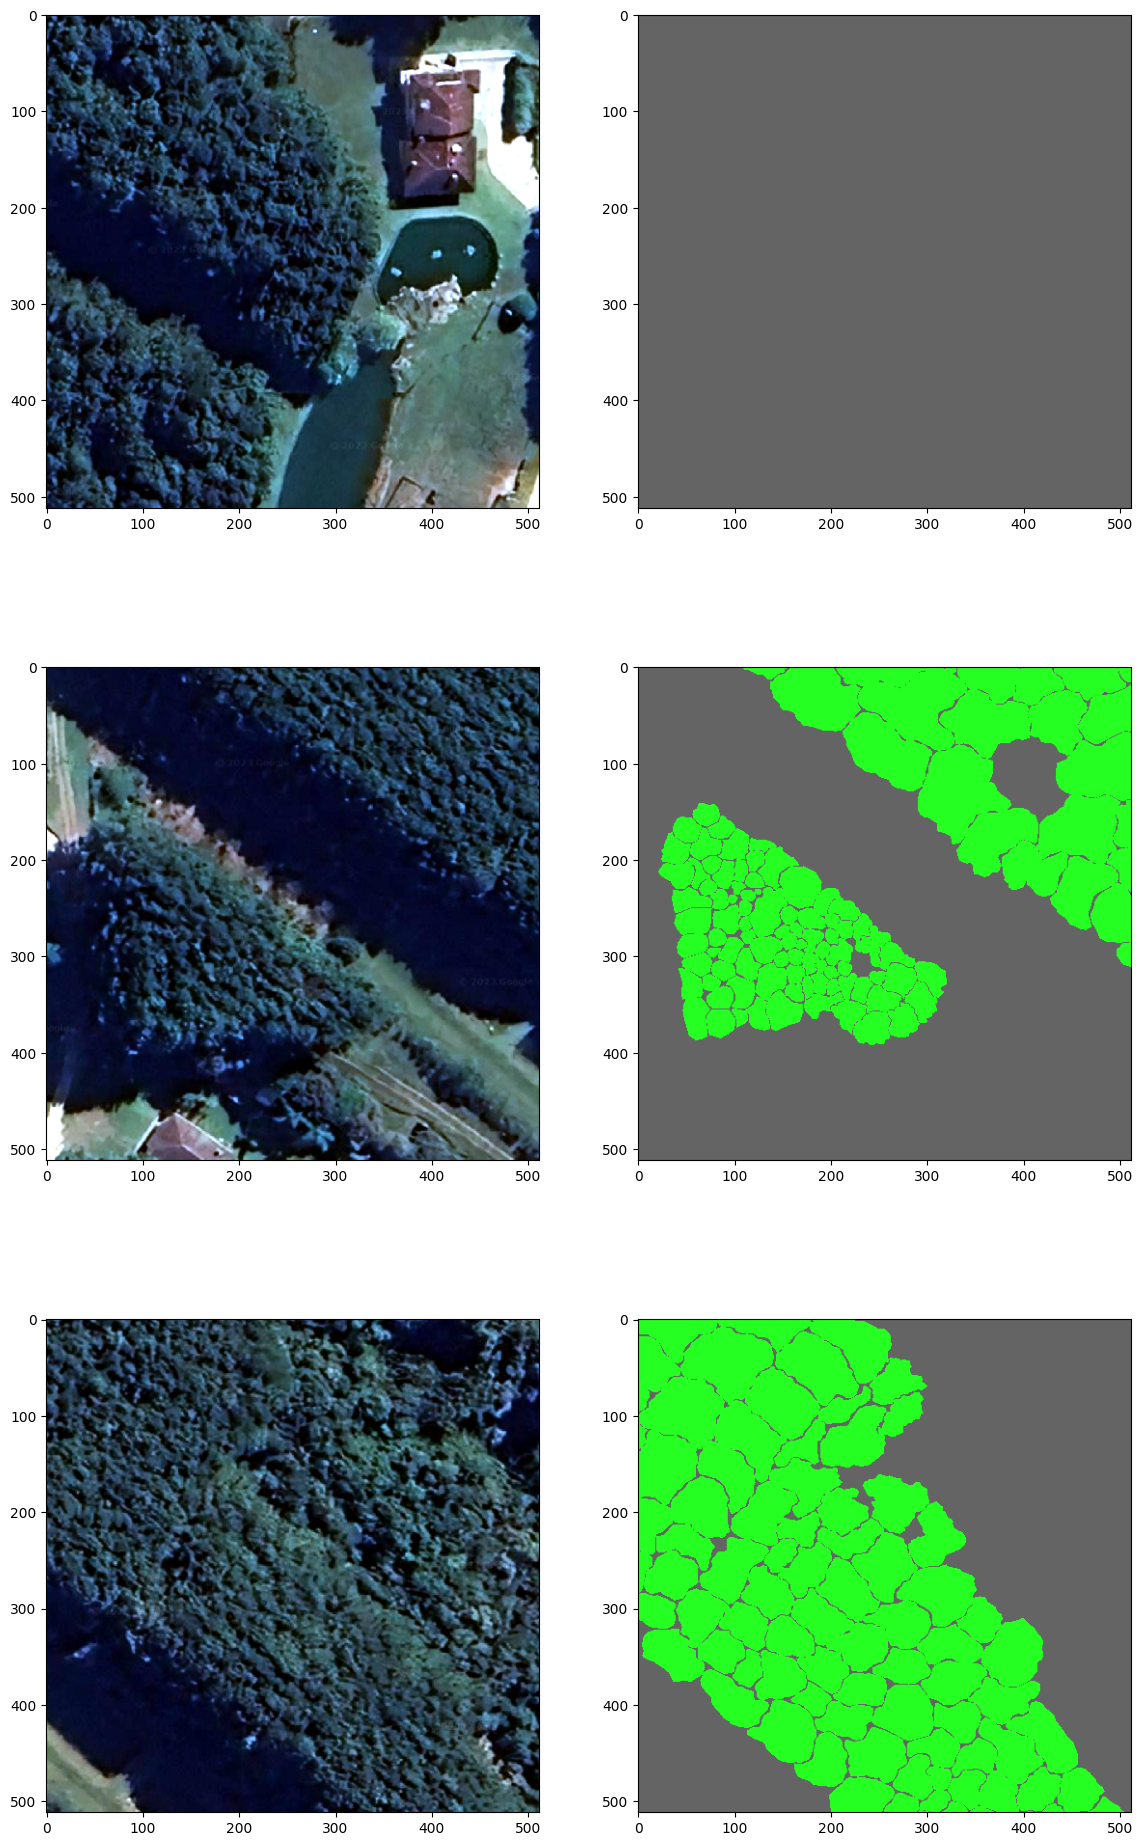

In [5]:
num_images = 3

fig, axs = plt.subplots(num_images, 2, figsize=(14, 8*num_images))

for i in range(num_images):
    axs[i, 0].imshow(image_dataset[i])
    axs[i, 1].imshow(mask_dataset[i], cmap='binary')

plt.show()

In [6]:
class_pinus = '#26ff22'
class_pinus = class_pinus.lstrip('#')
class_pinus = np.array(tuple(int(class_pinus[i:i+2], 16) for i in (0,2,4)))
print(class_pinus)

class_not_pinus = '#000000'
class_not_pinus = class_not_pinus.lstrip('#')
class_not_pinus = np.array(tuple(int(class_not_pinus[i:i+2], 16) for i in (0,2,4)))
print(class_not_pinus)

label = individual_patched_mask

[ 38 255  34]
[0 0 0]


In [7]:
def rgb_to_label(label):
    label_segment = np.zeros(label.shape, dtype=np.uint8)
    label_segment[np.all(label == class_pinus, axis=-1)] = 1
    label_segment[np.all(label == class_not_pinus, axis=-1)] = 0

    #print(label_segment)
    label_segment = label_segment[:,:,0]
    #print(label_segment)
    return label_segment

In [8]:
# Assuming mask_dataset contains your mask images
labels = []

for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1]


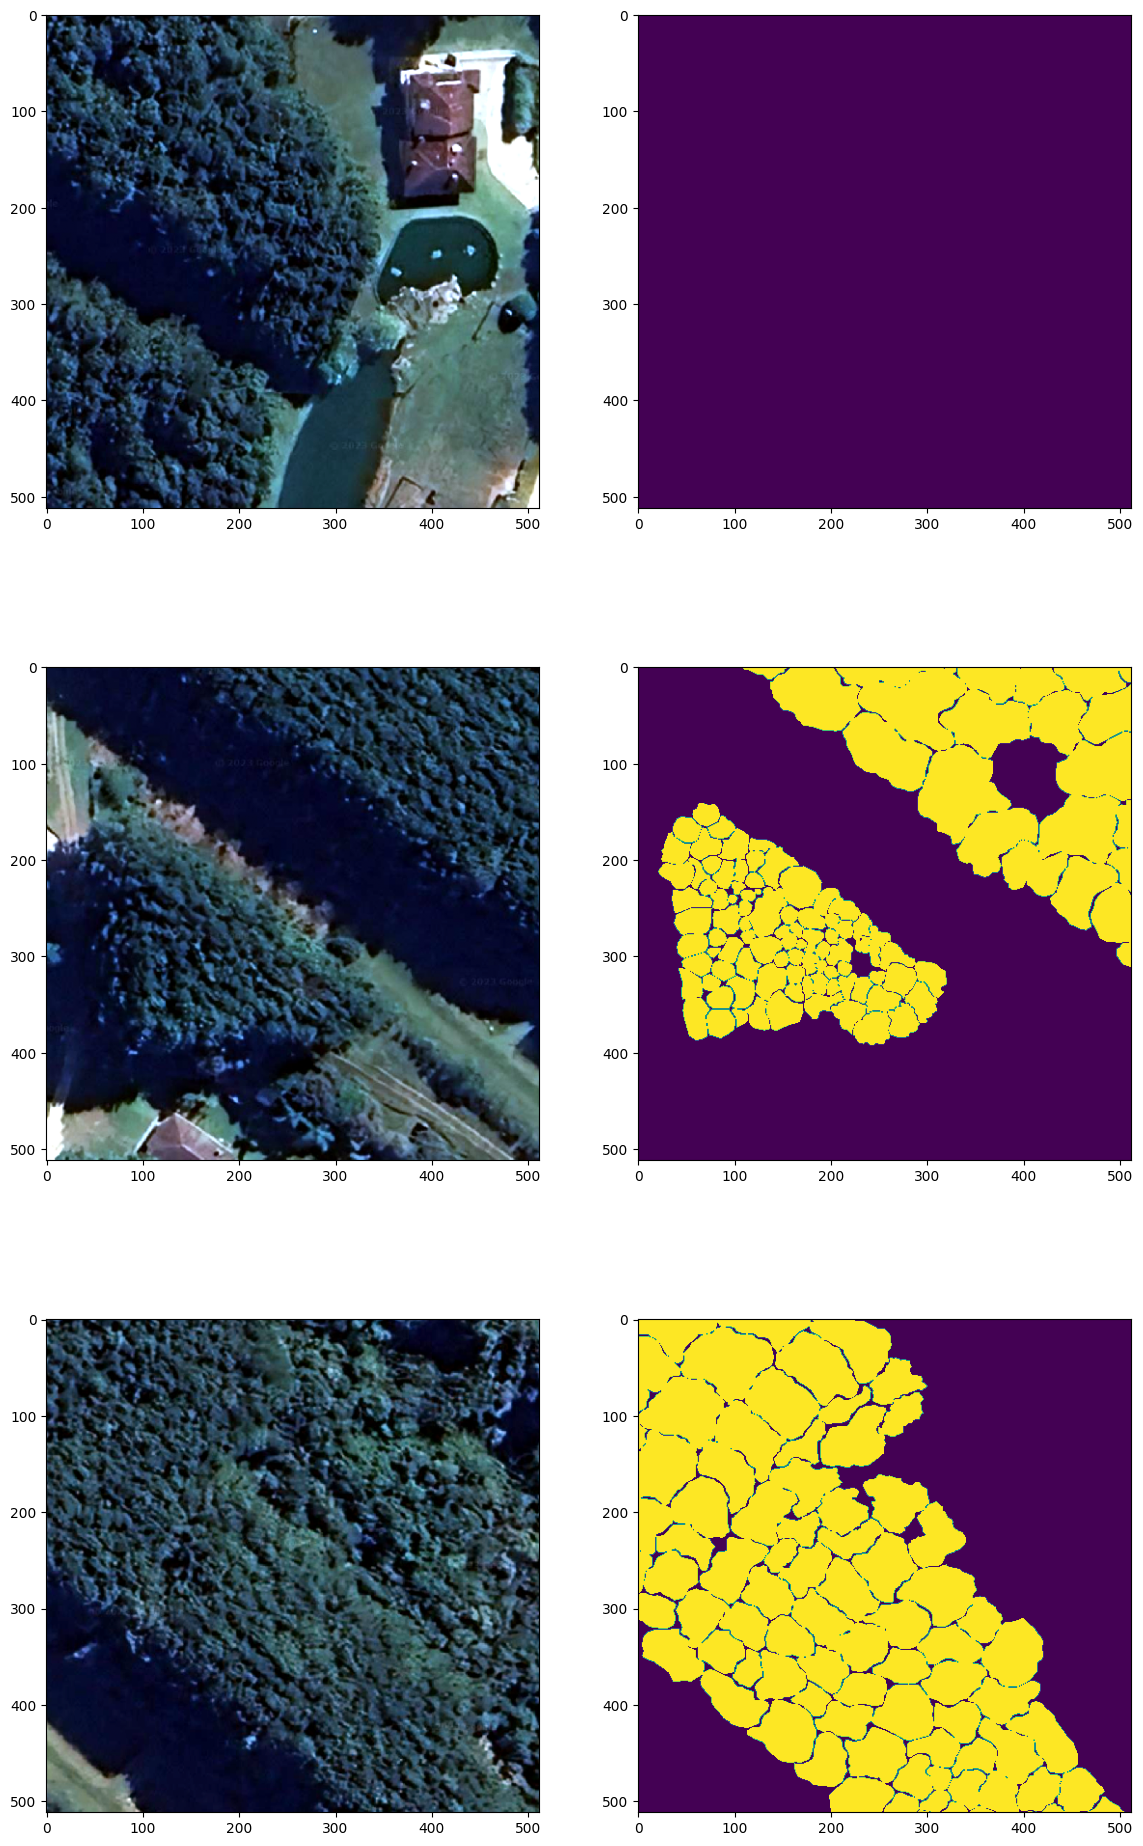

In [9]:
num_images = 3

fig, axs = plt.subplots(num_images, 2, figsize=(14, 8*num_images))

for i in range(num_images):
    axs[i, 0].imshow(image_dataset[i])
    axs[i, 1].imshow(labels[i][:, :, 0])

plt.show()

In [10]:
total_classes = len(np.unique(labels))
total_classes

2

In [11]:
labels_categorical_dataset = to_categorical(labels, num_classes = total_classes)
master_training_dataset = image_dataset

display(labels_categorical_dataset.shape)
display(master_training_dataset.shape)

(528, 512, 512, 2)

(528, 512, 512, 3)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(master_training_dataset, 
                                                    labels_categorical_dataset, 
                                                    test_size = 0.15, 
                                                    random_state = 42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(448, 512, 512, 3)
(448, 512, 512, 2)
(80, 512, 512, 3)
(80, 512, 512, 2)


In [13]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

## Jaccard coefficient

In [17]:
def jaccard_coef(y_true, y_pred):
    y_true_flatten = flatten(y_true)
    y_pred_flatten = flatten(y_pred)
    intersection = sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (sum(y_true_flatten) + sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

## Deep Learning (U-Net)

In [27]:
def multi_unet_model(n_classes=5, image_height=512, image_width=512, image_channels=1):
    inputs = Input((image_height, image_width, image_channels))
    source_input = inputs
    
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(source_input)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [28]:
metrics = ['accuracy', jaccard_coef]

In [29]:
def get_deep_learning_model():
    return multi_unet_model(n_classes = total_classes,
                            image_height = image_height,
                            image_width = image_width,
                            image_channels = image_channels)

In [31]:
model = get_deep_learning_model()
model.get_config()
model.save('../unet-deep-learning-pinus-classification/model.keras')

In [32]:
weights = [0.5, 0.5]

dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [34]:
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)

model_history = model.fit(X_train, 
                          y_train, 
                          batch_size=16, 
                          verbose=1, 
                          epochs=10, 
                          validation_data = (X_test, y_test), 
                          shuffle=False)

2024-08-10 11:18:17.562864: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1409286144 exceeds 10% of free system memory.


Epoch 1/10


2024-08-10 11:18:19.976411: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 939524096 exceeds 10% of free system memory.
2024-08-10 11:18:25.774061: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2024-08-10 11:18:26.013509: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2024-08-10 11:18:26.016030: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.


 6/28 ━━━━━━━━━━━━━━━━━━━━ 4:16 12s/step - accuracy: 0.5392 - jaccard_coef: 0.3332 - loss: 0.8164

KeyboardInterrupt: 

In [ ]:
history_a = model_history
history_a.history

In [ ]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model_history.params

In [ ]:
# Load a model
# model = tf.keras.models.load_model('../unet-deep-learning-pinus-classification/model.keras')

In [ ]:
y_pred = model.predict(X_test)
display(len(y_pred))
display(y_pred)

In [ ]:
y_pred_argmax = np.argmax(y_pred, axis=3)
display(len(y_pred_argmax))
display(y_pred_argmax)

In [ ]:
y_test_argmax = np.argmax(y_test, axis=3)
display(y_test_argmax)

In [ ]:
test_image_number = random.randint(0, len(X_test) - 1)

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)
plt.show()

In [ ]:
model.save("satellite_segmentation_full.h5")

In [ ]:
num_images = len(X_test)

# Create subplots with num_images rows and 3 columns (for input image, ground truth, and prediction)
fig, axs = plt.subplots(num_images, 3, figsize=(18, 6*num_images))

for i in range(num_images):
    test_image = X_test[i]
    ground_truth_image = y_test_argmax[i]

    test_image_input = np.expand_dims(test_image, 0)

    prediction = model.predict(test_image_input)
    predicted_image = np.argmax(prediction, axis=3)
    predicted_image = predicted_image[0, :, :]

    axs[i, 0].imshow(test_image)
    axs[i, 0].set_title('Input Image')
    axs[i, 1].imshow(ground_truth_image, cmap='binary')
    axs[i, 1].set_title('Ground Truth')
    axs[i, 2].imshow(predicted_image, cmap='binary')
    axs[i, 2].set_title('Predicted Image')

plt.tight_layout()
plt.show()

In [ ]:
# Assuming y_test and y_pred are one-hot encoded, get the predicted and true labels
y_test_flat = np.argmax(y_test, axis=-1).flatten()
y_pred_flat = np.argmax(y_pred, axis=-1).flatten()

In [ ]:
def flatten_func(y):
    return tf.reshape(y, [-1])

def jaccard_coef_func(y_true, y_pred):
    y_true_flatten = tf.cast(flatten_func(y_true), tf.float32)
    y_pred_flatten = tf.cast(flatten_func(y_pred), tf.float32)
    print(y_true_flatten)
    print(y_pred_flatten)
    
    intersection = tf.reduce_sum(tf.cast(y_true_flatten * y_pred_flatten, tf.float32))
    union = tf.reduce_sum(tf.cast(y_true_flatten + y_pred_flatten - y_true_flatten * y_pred_flatten, tf.float32))
    
    final_coef_value = (intersection + 1.0) / (union + 1.0)
    return final_coef_value

In [ ]:
accuracy = accuracy_score(y_test_flat, y_pred_flat)

print("Accuracy:", accuracy)
print("Recall:", recall_score(y_test_flat, y_pred_flat, average='macro'))
print("Precision:", precision_score(y_test_flat, y_pred_flat, average='macro'))
print("Jaccard Coefficient:", jaccard_coef_func(y_test, y_pred))

## RandomForest

In [14]:
def jaccard_coef(y_true, y_pred):
    y_true_flatten = flatten(y_true)
    y_pred_flatten = flatten(y_pred)
    intersection = sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (sum(y_true_flatten) + sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

In [15]:
# Flatten the image patches and corresponding labels
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

y_train_flat = y_train.reshape((y_train.shape[0], -1))

In [16]:
display(X_train.shape)
display(X_train_flat.shape)
display(X_test.shape)
display(X_test_flat.shape)
display(y_train.shape)
display(y_train_flat.shape)

(448, 512, 512, 3)

(448, 786432)

(80, 512, 512, 3)

(80, 786432)

(448, 512, 512, 2)

(448, 524288)

In [17]:
# Instantiate the RandomForestClassifier with verbose and random state
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100, verbose=2)

# Use joblib's parallel_backend to parallelize the fitting process
with parallel_backend('threading', n_jobs=2):
    # Fit the model
    rf_classifier.fit(X_train_flat, y_train_flat)

# Predict on the test set
y_pred_flat = rf_classifier.predict(X_test_flat)

# Reshape the predictions back to the original image dimensions
y_pred = y_pred_flat.reshape((X_test.shape[0], image_height, image_width, total_classes))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100


KeyboardInterrupt: 

In [ ]:
# Calculate Jaccard coefficient for the Random Forest model
jaccard_rf = jaccard_coef(y_test, y_pred)
print(f'Jaccard Coefficient for Random Forest: {jaccard_rf}')

## SegNet

In [33]:
def residual_block(input_tensor, filters):
    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    
    # Adjust the input tensor shape to match the output tensor shape
    if input_tensor.shape[-1] != filters:
        input_tensor = Conv2D(filters, (1, 1), padding='same', kernel_initializer='he_normal')(input_tensor)
    
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

def resnet_model(n_classes=2, image_height=512, image_width=512, image_channels=1):
    inputs = Input((image_height, image_width, image_channels))
    x = Conv2D(64, (7, 7), padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Residual Blocks (Encoder Part)
    for filters in [64, 128, 256, 512]:
        x = residual_block(x, filters)
    
    # Upsampling Layers (Decoder Part)
    x = UpSampling2D((2, 2))(x)  # This doubles the dimensions (e.g., from 256x256 to 512x512)
    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    
    # The following UpSampling would take us beyond 512x512, so we avoid it
    # Instead, we now focus on keeping the size controlled
    # Add a final convolution to reduce the number of channels to match n_classes
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(x)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [34]:
# Metrics and loss as before
metrics = ['accuracy', jaccard_coef]

# Define the model
model = resnet_model(n_classes=total_classes,
                     image_height=image_height,
                     image_width=image_width,
                     image_channels=image_channels)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 512, 512,  │      9,472 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_43       │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 256, 256,  │          0 │ activation_43[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 256, 256,  │     36,928 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_44       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 256, 256,  │     36,928 │ activation_44[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_45       │ (None, 256, 256,  │          0 │ add_14[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 256, 256,  │     73,856 │ activation_45[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_46       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 256, 256,  │    147,584 │ activation_46[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_60[0][0] 

 Total params: 6,091,266 (23.24 MB)

 Trainable params: 6,087,298 (23.22 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [35]:
weights = [0.5, 0.5]

# Define the loss
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# Compile the model
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)

In [36]:
# Train the model
model_history = model.fit(X_train, 
                          y_train, 
                          batch_size=16, 
                          verbose=1, 
                          epochs=10, 
                          validation_data=(X_test, y_test), 
                          shuffle=False)

# Save the model
model.save('../resnet-deep-learning-pinus-classification/model_segnet.keras')

2024-08-13 12:36:41.505309: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1409286144 exceeds 10% of free system memory.


Epoch 1/10
